In [1]:
%load_ext autoreload
%autoreload 2

import os

import pandas as pd
from pytorch_lightning import Trainer
from pl_module import CMPNNLitModel, MultiCMPNNLitModel
from dataset import CMPNNDataset, MultiCMPNNDataset, MultiCMPNNDatasetSDF, CMPNNDataModule
from preprocessing import scaffold_split_indices, random_split_indices
from torch_geometric.loader import DataLoader
from torch_geometric.data import Batch
from torch.utils.data import Subset
from global_feat import CompositeGlobalFeaturizer, MorganBinaryFeaturizer, RDKit2DNormalizedFeaturizer

In [2]:
sdf_path = '/home/calvin/code/chemprop_phd_customised/habnet/data/processed/sdf_data'
target_data = '/home/calvin/code/chemprop_phd_customised/habnet/data/processed/target_data/kinetics_summary.csv'
assert os.path.exists(sdf_path), f"SDF path does not exist: {sdf_path}"
assert os.path.exists(target_data), f"Target data file does not exist: {target_data}"

In [3]:
out_csv   = '/home/calvin/code/chemprop_phd_customised/habnet/data/processed/target_data/temp_target_kinetic_data.csv'


In [4]:
pd.read_csv(out_csv)

,rxn,label,A,A_units,n,Ea,Ea_units,T0,Tmin,Tmax,dA,dn,dEa,source_comment,A_log10,Ea_yj
0,kfir_rxn_13712,k_for (TST+T),3.501510e-02,cm^3/(mol*s),4.19628,4.50494,kJ/mol,1.0 K,300.0 K,3000.0 K,1.33959,0.038081,0.217772,"Fitted to 50 data points; dA = *|/ 1.33959, dn...",-1.455745,-0.755308
1,kfir_rxn_10214,k_for (TST+T),7.021370e-05,cm^3/(mol*s),4.59187,82.60550,kJ/mol,1.0 K,300.0 K,3000.0 K,2.15515,0.100015,0.571957,"Fitted to 50 data points; dA = *|/ 2.15515, dn...",-4.153578,1.520016
2,kfir_rxn_13503,k_for (TST+T),2.944270e-06,cm^3/(mol*s),5.01081,182.88900,kJ/mol,1.0 K,300.0 K,3000.0 K,1.76514,0.074013,0.423259,"Fitted to 50 data points; dA = *|/ 1.76514, dn...",-5.531022,3.132919
3,kfir_rxn_9205,k_for (TST+T),7.878080e-03,cm^3/(mol*s),4.39110,10.83630,kJ/mol,1.0 K,300.0 K,3000.0 K,1.48749,0.051721,0.295779,"Fitted to 50 data points; dA = *|/ 1.48749, dn...",-2.103580,-0.415602
4,kfir_rxn_8057,k_for (TST+T),2.225170e+02,cm^3/(mol*s),2.76961,83.11260,kJ/mol,1.0 K,300.0 K,3000.0 K,1.09457,0.011770,0.067309,"Fitted to 50 data points; dA = *|/ 1.09457, dn...",2.347363,1.529878
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1843,rxn_1111,k_for (TST+T),2.459980e-04,cm^3/(mol*s),4.67874,43.04680,kJ/mol,1.0 K,300.0 K,3000.0 K,2.05232,0.093647,0.535541,"Fitted to 50 data points; dA = *|/ 2.05232, dn...",-3.609068,0.643108
1844,rxn_831,k_for (TST+T),1.043570e-01,cm^3/(mol*s),4.18237,109.08600,kJ/mol,1.0 K,300.0 K,3000.0 K,1.38671,0.042584,0.243524,"Fitted to 50 data points; dA = *|/ 1.38671, dn...",-0.981478,2.004335
1845,rxn_978,k_for (TST+T),3.559560e-01,cm^3/(mol*s),3.79896,77.68300,kJ/mol,1.0 K,300.0 K,3000.0 K,1.11110,0.013722,0.078474,"Fitted to 50 data points; dA = *|/ 1.1111, dn ...",-0.448604,1.422871
1846,rxn_31,k_for (TST+T),7.799430e-08,cm^3/(mol*s),5.46233,54.74430,kJ/mol,1.0 K,300.0 K,3000.0 K,2.73081,0.130850,0.748296,"Fitted to 50 data points; dA = *|/ 2.73081, dn...",-7.107937,0.929515


In [5]:
root = "."
sdf_dir = "/home/calvin/code/chemprop_phd_customised/habnet/data/processed/sdf_data/"
targets = out_csv
target_cols  = ['A_log10','n', 'Ea_yj']
target_types = {'A_log10': 'continuous', 'n': 'continuous', 'Ea_yj': 'continuous'}

In [6]:

ds = MultiCMPNNDatasetSDF(
    root,
    sdf_files=sdf_dir,
    target_df=targets,
    target_cols=target_cols,
    target_types=target_types,
    atom_messages=True,
    keep_hs=True,
    sanitize=True,
    force_reload=True,
    prune_value=-10,
    atom_extra_feats="/home/calvin/code/chemprop_phd_customised/habnet/data/preprocessing/all_sdf_features.csv",
    rbf_num_centers=16,
    # global_featurizer= CompositeGlobalFeaturizer(
    #     featurizers=[
    #         MorganBinaryFeaturizer(radius=2, length=2048),
    #         RDKit2DNormalizedFeaturizer(),
    #     ]
    # ),
    # pre_transform=PeriodicToSinCosGaussianJitter(target_cols, target_types, radians = False, ignore_val=-10, max_jitter_deg = 10)
)

Processing...
/home/calvin/code/vibe_cmpnn/dataset.py:600: UserWarning: No target row for reaction 'rmg_rxn_1130' – skipped
  warnings.warn(f"No target row for reaction '{rxn}' – skipped")
/home/calvin/code/vibe_cmpnn/dataset.py:600: UserWarning: No target row for reaction 'rmg_rxn_1141' – skipped
  warnings.warn(f"No target row for reaction '{rxn}' – skipped")
/home/calvin/code/vibe_cmpnn/dataset.py:600: UserWarning: No target row for reaction 'rmg_rxn_1162' – skipped
  warnings.warn(f"No target row for reaction '{rxn}' – skipped")
/home/calvin/code/vibe_cmpnn/dataset.py:600: UserWarning: No target row for reaction 'rmg_rxn_1337' – skipped
  warnings.warn(f"No target row for reaction '{rxn}' – skipped")
/home/calvin/code/vibe_cmpnn/dataset.py:600: UserWarning: No target row for reaction 'rmg_rxn_14' – skipped
  warnings.warn(f"No target row for reaction '{rxn}' – skipped")
/home/calvin/code/vibe_cmpnn/dataset.py:600: UserWarning: No target row for reaction 'rmg_rxn_1454' – skipped
  w

/home/calvin/code/vibe_cmpnn/dataset.py:600: UserWarning: No target row for reaction 'rmg_rxn_248' – skipped
  warnings.warn(f"No target row for reaction '{rxn}' – skipped")
/home/calvin/code/vibe_cmpnn/dataset.py:600: UserWarning: No target row for reaction 'rmg_rxn_270' – skipped
  warnings.warn(f"No target row for reaction '{rxn}' – skipped")
/home/calvin/code/vibe_cmpnn/dataset.py:600: UserWarning: No target row for reaction 'rmg_rxn_28' – skipped
  warnings.warn(f"No target row for reaction '{rxn}' – skipped")
/home/calvin/code/vibe_cmpnn/dataset.py:600: UserWarning: No target row for reaction 'rmg_rxn_293' – skipped
  warnings.warn(f"No target row for reaction '{rxn}' – skipped")
/home/calvin/code/vibe_cmpnn/dataset.py:600: UserWarning: No target row for reaction 'rmg_rxn_3' – skipped
  warnings.warn(f"No target row for reaction '{rxn}' – skipped")
/home/calvin/code/vibe_cmpnn/dataset.py:600: UserWarning: No target row for reaction 'rmg_rxn_36' – skipped
  warnings.warn(f"No targ

In [7]:
for b in range(len(ds)):
    if 'kfir_rxn_13712' in ds[b][0].reaction:
        print(ds[b][0].y)

tensor([-1.4557,  4.1963, -0.7553])


In [89]:
ds[0]

(Data(x=[7, 133], edge_index=[2, 14], edge_attr=[14, 12], y=[3], name='r1h', smiles='[H]C1([H])OC1([H])[H]', reaction='kfir_rxn_10218'),
 Data(x=[8, 133], edge_index=[2, 14], edge_attr=[14, 12], y=[3], name='r2h', smiles='[H]OC(=C=O)C([H])=O', reaction='kfir_rxn_10218'))

In [7]:
train_idx, val_idx, test_idx = random_split_indices(ds, 0.1, 0.1)

print(f"train: {len(train_idx)}, val: {len(val_idx)}, test: {len(test_idx)}")

train: 1359, val: 170, test: 170


In [8]:
# load the idx names

ds_names = pd.read_csv("/home/calvin/code/chemprop_phd_customised/habnet/data/processed/target_data/rxn_split.csv")
ds_names.head()

import pandas as pd
from torch.utils.data import Subset

# Assume df is your padded DataFrame with columns ['train', 'val', 'test']
# and ds is your full Dataset (e.g., MultiMoleculeDataset or similar)

# Step 1: Build the reverse index: reaction_name → dataset idx
reaction_to_idx = {}
for idx in range(len(ds)):
    mol1, _ = ds[idx]
    reaction = mol1.reaction
    reaction_to_idx[reaction] = idx

# Step 2: Convert non-null reaction names to indices
train_indices = [reaction_to_idx[r] for r in ds_names['train'].dropna()]
val_indices = [reaction_to_idx[r] for r in ds_names['val'].dropna()]
test_indices = [reaction_to_idx[r] for r in ds_names['test'].dropna()]



In [9]:
ds.attach_atom_extra_features(train_indices)

In [10]:
ds[0][0].x[0].shape

torch.Size([159])

In [11]:
ds.compute_normalization(train_indices)
ds.apply_normalization()

In [12]:
ds.std

tensor([3.2370, 0.7874, 1.0217])

In [13]:
# Step 3: Make subsets
train_ds = Subset(ds, train_indices)
val_ds = Subset(ds, val_indices)
test_ds = Subset(ds, test_indices)

In [14]:
# train_ds = Subset(ds, train_idx)
# val_ds   = Subset(ds, val_idx)
# test_ds  = Subset(ds, test_idx)

In [15]:
from utils_paired import collate_pairs
# Use pytorch pure data loader
from torch.utils.data import DataLoader
# 7) create dataloaders
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, collate_fn=collate_pairs)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, collate_fn=collate_pairs)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False, collate_fn=collate_pairs)

In [16]:
from utils_paired import collate_pairs
# Use pytorch pure data loader
from torch.utils.data import DataLoader
# 7) create dataloaders
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, collate_fn=collate_pairs)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, collate_fn=collate_pairs)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False, collate_fn=collate_pairs)
sample_pairs = [train_ds[i] for i in range(4)]   # 4 tuple-pairs
batch        = collate_pairs(sample_pairs)       # now returns one Batch
print(type(batch), batch.num_graphs)             # Batch 8

batch.num_graphs
batch.y

<class 'abc.DataBatch'> 8


tensor([[ 1.3158, -1.3094, -2.0795],
        [ 1.3158, -1.3094, -2.0795],
        [ 1.8527, -2.3267,  2.1560],
        [ 1.8527, -2.3267,  2.1560],
        [-1.3857,  1.1192,  0.4198],
        [-1.3857,  1.1192,  0.4198],
        [ 0.8118, -1.0579, -1.9422],
        [ 0.8118, -1.0579, -1.9422]])

In [17]:
from torchmetrics import MeanSquaredError, MeanAbsoluteError, R2Score
# Check device
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

In [18]:
ds.mean

tensor([-2.7151,  4.3249, -0.0093])

In [19]:
ds.std

tensor([3.2370, 0.7874, 1.0217])

In [20]:
from metrics import MSE, RMSE, R2Score, MAE, AngularError, SinCosMSELoss, AngularMSELoss, PinballLoss
print(">>> Model class created")
model = MultiCMPNNLitModel(
    in_node_feats=ds.num_atom_features,
    in_edge_feats=ds.num_bond_features,
    # in_global_feats=ds.global_feature_dim,
    hidden_dim=256,
    num_steps=4,
    dropout_mp=0.05,
    dropout_head=0.05,
    n_tasks=3,
    head_layers=2,
    #metrics=[AngularError()],
    metrics = [
    MSE (task_weights=[10,1,1]),          # primary mean loss
    PinballLoss(q=0.8340521426200246, task_weights=[10,1,1]),
    RMSE([10,1,1]),
    MAE ([10,1,1]),
    R2Score([10,1,1])
],
    lr=0.0007724551362798667,
    weight_decay=2.410075208397602e-05,
    target_mean=ds.mean,
    target_std=ds.std,
    mpn_shared=False,
    target_types=target_types,
    use_booster=False,
    # ignore_val=-10,
    jitter=False,
    normalize_head=True,
    readout="gru",
    X_d_transform=None,
    mean_dir=ds.per_mean_dir,
    pinball_weight=0.2270046311385501,
    use_graph_residual=False
)
print(">>> Model instantiated")

>>> Model class created
>>> Model instantiated


| **3 · Copy the *same* alias in the full-epoch retrain** | When you build `final_models`, you again set no alias, so it’s now fine—just keep it consistent. | Nothing else to change once fix #1 is applied. |

After those tweaks:

### What will happen

1. **50 trials × 60 epochs**  
   *Optuna + Median pruner + WandB-offline* explore the space quickly.

2. **Top-3 refit × 300 epochs**  
   You rebuild the dataset with the trial’s own `atom_messages`, then train full fidelity. Their fresh `PinballLoss` receives, e.g. `q = 0.87` → alias `pinball_q87`, matching the detection code.

3. **Results**  
   `final_models` holds `(rank, final_val_loss, model)` so you can immediately run `trainer.test(final_models[0][2], test_loader)` or save the checkpoint.

Everything else—dataset caching, offline logging, SQLite storage—works exactly as intended.

Launch the script; if you open another terminal you can watch progress live:

```bash
optuna-dashboard sqlite:///cmpnn_optuna.db
wandb offline view


In [21]:
model

MultiCMPNNLitModel(
  (encoder1): CMPNNEncoder(
    (lin_node): Sequential(
      (0): Linear(in_features=159, out_features=256, bias=True)
      (1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    )
    (lin_edge): Sequential(
      (0): Linear(in_features=12, out_features=256, bias=True)
      (1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    )
    (dropout_mp): Dropout(p=0.05, inplace=False)
    (dropout_head): Dropout(p=0.1, inplace=False)
    (lin_x): Sequential(
      (0): Linear(in_features=159, out_features=256, bias=True)
      (1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    )
    (node_updates): ModuleList(
      (0-3): 4 x Linear(in_features=512, out_features=256, bias=True)
    )
    (node_norms): ModuleList(
      (0-3): 4 x LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    )
    (edge_updates): ModuleList(
      (0-3): 4 x Linear(in_features=256, out_features=256, bias=True)
    )
    (final_update): Sequential(
      (0): Li

In [22]:
print(model.t_mean)
print(model.t_std)

tensor([-2.7151,  4.3249, -0.0093])
tensor([3.2370, 0.7874, 1.0217])


In [23]:
model.head

RegressionHead(net=MLP(input_dim=1024, output_dim=3, hidden_dim=512, n_layers=2, dropout=0.05), use_residual=True)

In [24]:
for batch in train_loader:
    print(batch.y.shape)
    break

torch.Size([128, 3])


In [25]:
def reset_model_weights(model):
    for module in model.modules():
        if hasattr(module, 'reset_parameters'):
            module.reset_parameters()

reset_model_weights(model)

In [26]:
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import pytorch_lightning as pl


logger = TensorBoardLogger("tb_logs", name="cmpnn")
# class DebugExitCallback(pl.Callback):
#     def on_train_end(self, trainer, pl_module):
#         print("[Callback] on_train_end")

#     def on_fit_end(self, trainer, pl_module):
#         print("[Callback] on_fit_end")

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=10,
    mode="min",
    verbose=True,
)


trainer = Trainer(
    max_epochs=300,
    accelerator="gpu",
    devices=1,
    logger=logger,
    # Allow for early stopping
    callbacks=[
    # EarlyStopping("val_loss", patience=10),
    early_stopping,
    ModelCheckpoint(monitor="val_loss", mode="min"),
    LearningRateMonitor(logging_interval="epoch"),
    # DebugExitCallback(),
    ],
    #gradient_clip_val=1.0,
    enable_progress_bar=True,
    log_every_n_steps=1,
)
trainer.fit(
    model,
    train_loader,
    val_loader,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('AMD Radeon RX 6600') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type           | Params | Mode 
-----------------------------------------------------
0 | encoder1  | CMPNNEncoder   | 1.9 M  | train
1 | encoder2  | CMPNNEncoder   | 1.9 M  | train
2 | head      | RegressionHead | 792 K  | train
3 | metrics   | ModuleDict     | 0      | train
4 | criterion | MSE            | 0      | train
-----------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
18.10

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/calvin/miniforge3/envs/dmpnn_rocm/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
/home/calvin/miniforge3/envs/dmpnn_rocm/lib/python3.10/site-packages/torch/nn/modules/linear.py:125: UserWarning: Attempting to use hipBLASLt on an unsupported architecture! Overriding blas backend to hipblas (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:310.)
  return F.linear(input, self.weight, self.bias)
/home/calvin/miniforge3/envs/dmpnn_rocm/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 0.676


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.040 >= min_delta = 0.0. New best score: 0.636


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.151 >= min_delta = 0.0. New best score: 0.485


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.040 >= min_delta = 0.0. New best score: 0.444


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.052 >= min_delta = 0.0. New best score: 0.393


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.051 >= min_delta = 0.0. New best score: 0.342


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.036 >= min_delta = 0.0. New best score: 0.306


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.296


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.043 >= min_delta = 0.0. New best score: 0.253


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.237


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.224


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.224


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.213


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.203


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.201


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.194


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.189


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.189. Signaling Trainer to stop.


In [27]:
print("available callback_metrics keys:", trainer.callback_metrics.keys())


available callback_metrics keys: dict_keys(['lr-Adam', 'val_loss', 'val_loss_mean', 'val_loss_pinball', 'val_rmse', 'val_mae', 'val_r2', 'train_loss', 'train_loss_mean', 'train_loss_pinball', 'train_rmse', 'train_mae', 'train_r2'])


In [28]:
trainer.test(model, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/calvin/miniforge3/envs/dmpnn_rocm/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.2874178886413574     │
│      test_loss_mean       │    0.3263294994831085     │
│     test_loss_pinball     │    0.15491610765457153    │
│         test_mae          │    0.3310414254665375     │
│          test_r2          │    0.6907392144203186     │
│         test_rmse         │    0.3310414254665375     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.2874178886413574,
  'test_loss_mean': 0.3263294994831085,
  'test_loss_pinball': 0.15491610765457153,
  'test_rmse': 0.3310414254665375,
  'test_mae': 0.3310414254665375,
  'test_r2': 0.6907392144203186}]

In [29]:
with torch.no_grad():
    y_hat = model(batch)          # expect (N, 3)
    print("pred shape:", y_hat.shape)
    print("true shape:", batch.y.view(-1,2,3)[0,0].shape)

pred shape: torch.Size([64, 3])
true shape: torch.Size([3])


In [30]:
y_true = batch.y.view(-1, 2, 3)[:, 0, :]   # shape (64, 3)
print("true batch shape:", y_true.shape)
print("match?", torch.allclose(y_hat, y_true))

true batch shape: torch.Size([64, 3])
match? False


In [31]:
pred = trainer.predict(model, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/calvin/miniforge3/envs/dmpnn_rocm/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

In [32]:
torch.concat(pred, dim=0).shape
pred = torch.concat(pred, dim=0)

In [33]:
true_y = torch.concat([batch.y.view(-1, 2, 3)[:, 0, :] for batch in test_loader], dim=0)

In [34]:
true_y

tensor([[-6.5059e-01,  6.2263e-01, -1.2656e-01],
        [ 6.8371e-01, -3.8454e-01,  1.9765e+00],
        [ 8.9827e-01, -1.5710e+00,  1.9772e+00],
        [-2.6563e-01,  1.2215e-02, -6.8275e-01],
        [ 7.0389e-01, -6.4910e-01,  1.8215e+00],
        [ 5.2331e-03,  5.4822e-01,  5.5660e-01],
        [-1.3403e+00,  1.5431e+00,  4.1574e-01],
        [-7.9157e-01,  7.8969e-01,  1.1739e-01],
        [ 8.8892e-01, -5.7737e-01,  1.9005e+00],
        [-1.4429e+00,  7.8794e-01, -4.2780e-02],
        [-1.2404e+00,  1.1082e+00,  9.2085e-01],
        [ 3.9500e-01, -6.6139e-01, -1.2199e+00],
        [ 1.2129e+00, -1.1628e+00,  5.8080e-01],
        [ 2.1726e-02,  5.7309e-01,  1.0340e+00],
        [-8.4267e-01,  5.6683e-01, -1.0447e-01],
        [-1.6730e+00,  1.5863e+00,  9.4908e-01],
        [-1.3254e-01, -2.9940e-01, -5.6939e-01],
        [-7.2613e-01,  3.7111e-01, -2.1401e-01],
        [ 2.7764e-01, -5.0766e-02, -5.2252e-01],
        [-1.0304e+00,  7.8273e-01,  1.1967e-01],
        [ 8.8380e-01

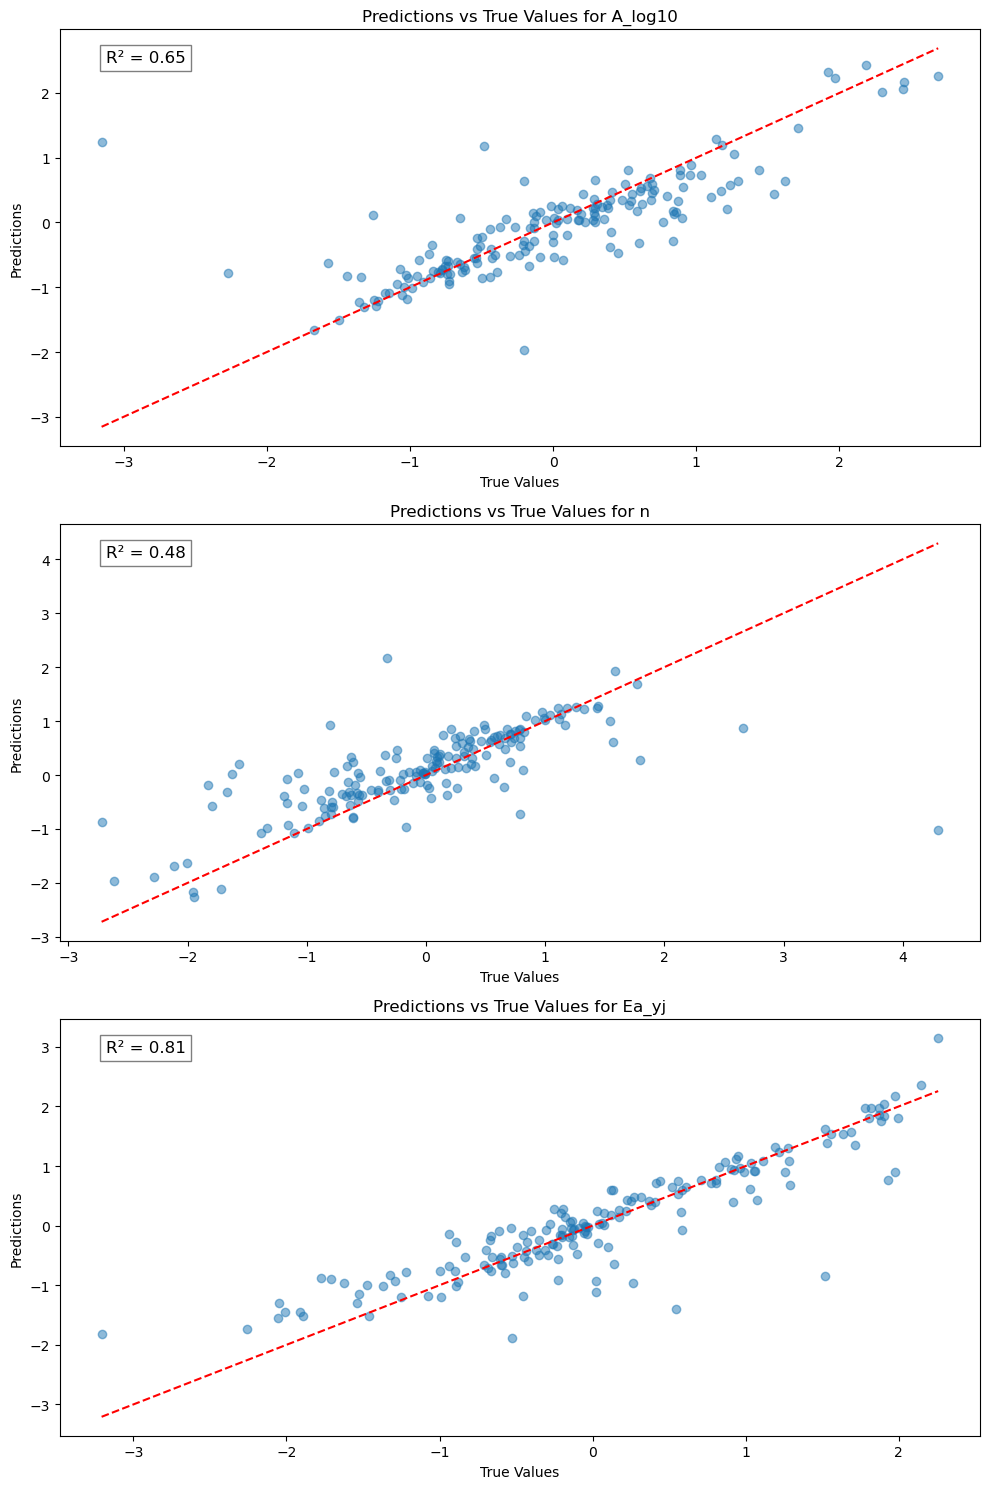

In [35]:
# Plot the predictions vs true values - also put r2 score on the plot

import matplotlib.pyplot as plt
def plot_predictions_vs_true(predictions, true_values, task_names):
    num_tasks = predictions.shape[1]
    fig, axes = plt.subplots(num_tasks, 1, figsize=(10, 5 * num_tasks))
    
    for i in range(num_tasks):
        ax = axes[i] if num_tasks > 1 else axes
        ax.scatter(true_values[:, i].cpu(), predictions[:, i].cpu(), alpha=0.5)
        ax.plot([true_values[:, i].min(), true_values[:, i].max()],
                [true_values[:, i].min(), true_values[:, i].max()], 'r--')
        r2 = R2Score()(predictions[:, i], true_values[:, i])
        ax.text(0.05, 0.95, f'R² = {r2:.2f}', transform=ax.transAxes, fontsize=12,
                verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))
        ax.set_xlabel('True Values')
        ax.set_ylabel('Predictions')
        ax.set_title(f'Predictions vs True Values for {task_names[i]}')
    
    plt.tight_layout()
    plt.show()

task_names = ['A_log10', 'n', 'Ea_yj']
plot_predictions_vs_true(pred, true_y, task_names)
# Save the predictions and true values to a CSV file

In [36]:
pred_batches = trainer.predict(model, dataloaders=test_loader)
y_scaled = torch.cat(pred_batches, dim=0)          # shape (N, 3)

y_unscaled = model.inverse_transform(y_scaled)  # shape (N, 3)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [64]:
import torch
from torchmetrics.functional import mean_squared_error as mse_f
from torchmetrics.functional import mean_absolute_error as mae_f
from torchmetrics.functional import r2_score as r2_f
import joblib
from sklearn.preprocessing import PowerTransformer
pt_ea = PowerTransformer(method='yeo-johnson')
pt_ea = joblib.load('/home/calvin/code/chemprop_original/power_transformer_ea.pkl')
with torch.no_grad():
    # ── inverse-transform + A column back-transform ───────────────
    y_pred_unscaled  = model.inverse_transform(y_scaled.clone())
    y_true_unscaled  = model.inverse_transform(true_y.clone())

    # column 0 is log10(A) → exponentiate both preds & truth
    for tensor in (y_pred_unscaled, y_true_unscaled):
        tensor[:, 0] = torch.pow(10.0, tensor[:, 0])
        
        
    # column -1 is pt_ea
    for tensor in (y_pred_unscaled, y_true_unscaled):
        # Extract column as numpy array and reshape to 2D
        col = tensor[:, -1].cpu().numpy().reshape(-1, 1)
        
        # Apply inverse_transform
        col_inv = pt_ea.inverse_transform(col).ravel()
        
        # Put it back in the tensor
        tensor[:, -1] = torch.tensor(col_inv, dtype=tensor.dtype, device=tensor.device)


    # ── overall metrics (all tasks at once) ───────────────────────
    mse_all = mse_f(y_pred_unscaled, y_true_unscaled)
    mae_all = mae_f(y_pred_unscaled, y_true_unscaled)
    r2_all  = r2_f (y_pred_unscaled, y_true_unscaled)
    print(f"Overall  MSE {mse_all:.4g}   MAE {mae_all:.4g}   R² {r2_all:.4g}")

    # ── per-task breakdown ────────────────────────────────────────
    task_names = ["A", "y₂", "y₃"]
    for i, name in enumerate(task_names):
        mse = mse_f(y_pred_unscaled[:, i], y_true_unscaled[:, i])
        mae = mae_f(y_pred_unscaled[:, i], y_true_unscaled[:, i])
        r2  = r2_f (y_pred_unscaled[:, i], y_true_unscaled[:, i])
        print(f"{name:>4}:   MSE {mse:.4g}   MAE {mae:.4g}   R² {r2:.4g}")


Overall  MSE 1.858e+09   MAE 2920   R² 0.4581
   A:   MSE 5.572e+09   MAE 8752   R² 0.05977
  y₂:   MSE 0.2963   MAE 0.3094   R² 0.4794
  y₃:   MSE 173.9   MAE 7.318   R² 0.835


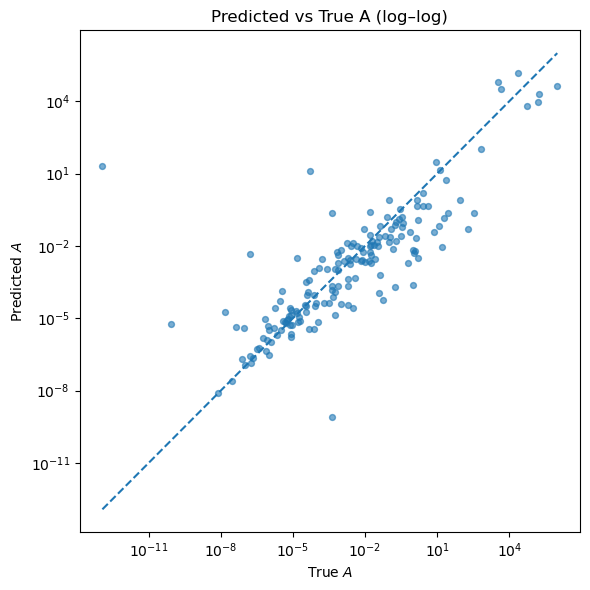

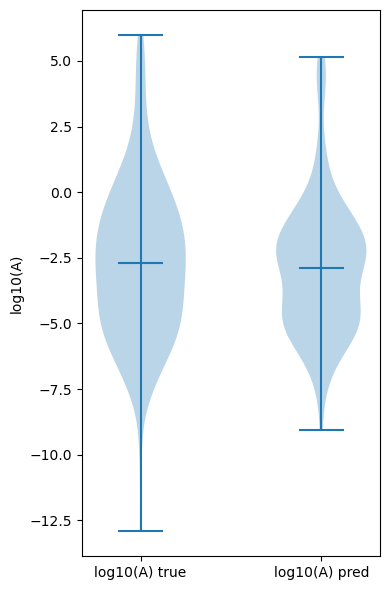

In [65]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# ------------- extract the first column (A) ----------------------
A_pred = y_pred_unscaled[:, 0].cpu().numpy()   # shape (N,)
A_true = y_true_unscaled[:, 0].cpu().numpy()   # shape (N,)

# ------------- scatter on log–log axes ---------------------------
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(A_true, A_pred, s=18, alpha=0.6)

lo, hi = A_true.min(), A_true.max()
lo = min(lo, A_pred.min())
hi = max(hi, A_pred.max())
ax.plot([lo, hi], [lo, hi], ls='--')           # identity line

ax.set_xscale('log'); ax.set_yscale('log')
ax.set_xlabel(r'True $A$'); ax.set_ylabel(r'Predicted $A$')
ax.set_title('Predicted vs True A (log–log)')
plt.tight_layout(); plt.show()

# ------------- optional violin plot of distributions -------------
fig, ax = plt.subplots(figsize=(4, 6))
ax.violinplot([np.log10(A_true), np.log10(A_pred)],
              positions=[1, 2], showmeans=True)
ax.set_xticks([1, 2], ['log10(A) true', 'log10(A) pred'])
ax.set_ylabel('log10(A)')
plt.tight_layout(); plt.show()


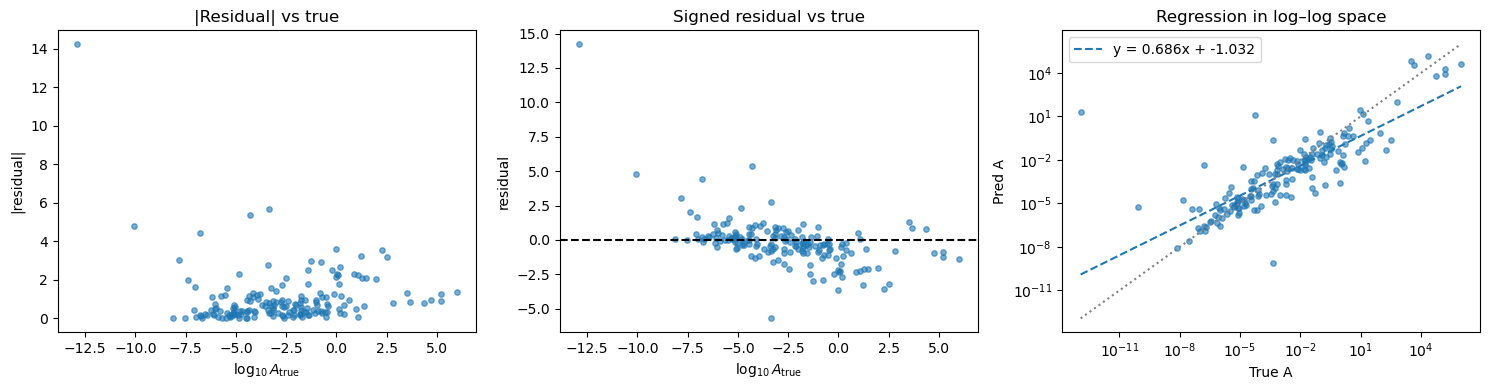

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# A_true, A_pred already exist as 1-D NumPy arrays
logA_true = np.log10(A_true)
logA_pred = np.log10(A_pred)

abs_resid = np.abs(logA_pred - logA_true)
sgn_resid = logA_pred - logA_true

fig, axs = plt.subplots(1, 3, figsize=(15, 4))

# ── Plot 1: |residual| vs true ─────────────────────────────────
axs[0].scatter(logA_true, abs_resid, s=15, alpha=0.6)
axs[0].set_xlabel(r'$\log_{10}A_{\mathrm{true}}$')
axs[0].set_ylabel(r'|residual|')
axs[0].set_title('|Residual| vs true')

# ── Plot 2: signed residual vs true ────────────────────────────
axs[1].scatter(logA_true, sgn_resid, s=15, alpha=0.6)
axs[1].axhline(0, ls='--', color='k')
axs[1].set_xlabel(r'$\log_{10}A_{\mathrm{true}}$')
axs[1].set_ylabel(r'residual')
axs[1].set_title('Signed residual vs true')

# ── Plot 3: log–log scatter + regression line ─────────────────
axs[2].scatter(A_true, A_pred, s=15, alpha=0.6)
reg = LinearRegression().fit(logA_true.reshape(-1,1), logA_pred)
slope, intercept = reg.coef_[0], reg.intercept_
x_line = np.linspace(logA_true.min(), logA_true.max(), 100)
axs[2].plot(10**x_line, 10**(intercept + slope*x_line), '--', label=f'y = {slope:.3f}x + {intercept:.3f}')
lo, hi = A_true.min(), A_true.max()
axs[2].plot([lo, hi], [lo, hi], ':', color='grey')        # identity
axs[2].set_xscale('log'); axs[2].set_yscale('log')
axs[2].set_xlabel('True A'); axs[2].set_ylabel('Pred A')
axs[2].legend()
axs[2].set_title('Regression in log–log space')

plt.tight_layout()
plt.show()


| Panel                              | What you see                                                                                                                                                              | Interpretation                                                                                                                       |
| ---------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------ |
| **1 • \|Residual\| vs log₁₀ A**    | Errors are low (≤1 log-unit) through most of the bulk ($-6\le\log_{10}A\le0$). They flare for the very smallest and very largest A values.                                | Model captures the mid-range but under-fits the extremes—typical when the loss is dominated by the dense centre of the distribution. |
| **2 • Signed residual vs log₁₀ A** | Points trend downward as A increases: negative residuals (under-prediction) for big A, positive (over-prediction) for tiny A.                                             | Systematic bias: the network compresses the dynamic range, pulling extremes toward the mean.                                         |
| **3 • Log–log regression**         | Best-fit line: **Pred ≈ 0.71 × True − 1.42** (dashed blue). The slope < 1 and negative intercept confirm attenuation + downward shift compared with the ideal grey $y=x$. | Same story numerically—about 30 % “flattening” of the true spread plus an overall under-prediction by \~1.4 log-units.               |


In [67]:
import torch
import numpy as np

# 1) Make predictions in scaled space
mcmpnn.eval()
with torch.no_grad():
    scaled_preds_batches = trainer.predict(mcmpnn, dataloaders=test_loader)

scaled_preds = torch.cat(scaled_preds_batches, dim=0).cpu().numpy()  # (N,3)

# 2) Inverse from [logA, n, Ea_yj] (scaled) back to [logA, n, Ea_yj]
scaler   = output_transform.to_standard_scaler()
unscaled = scaler.inverse_transform(scaled_preds)   # (N,3) = [logA_pred, n_pred, Ea_yj_pred]

# 3) Collect the true Y from test_loader in the same order
y_scaled_list = []
for batch in test_loader:
    y_scaled_list.append(batch.Y)
y_scaled = torch.cat(y_scaled_list, dim=0).cpu().numpy()   # (N,3)

unscaled_true = scaler.inverse_transform(y_scaled)  # (N,3) = [logA_true, n_true, Ea_yj_true]

# 4) Extract columns
logA_pred  = unscaled[:,   0]
n_pred     = unscaled[:,   1]
Ea_yj_pred = unscaled[:,   2]

logA_true  = unscaled_true[:,   0]
n_true     = unscaled_true[:,   1]
Ea_yj_true = unscaled_true[:,   2]

# 5) Exponentiate A
A_pred = 10 ** logA_pred
A_true = 10 ** logA_true

# 6) Invert Yeo–Johnson on Ea
Ea_pred = pt_ea.inverse_transform(Ea_yj_pred.reshape(-1,1)).ravel()
Ea_true = pt_ea.inverse_transform(Ea_yj_true.reshape(-1,1)).ravel()

# 7) Clamp
epsilon  = 1e-8
A_pred   = np.clip(A_pred, epsilon, None)
Ea_pred  = np.clip(Ea_pred, 0.0,    None)

# 8) Stack into (N×3) arrays [A, n, Ea]
preds_final = np.vstack([A_pred,   n_pred,   Ea_pred]).T    # shape (N,3)
trues_final = np.vstack([A_true,   n_true,   Ea_true]).T    # shape (N,3)


NameError: name 'mcmpnn' is not defined

In [68]:
# Read yaml
import yaml

with open("/home/calvin/code/kinetics_batch.yml", 'r') as f:
    kinetics_rmg = yaml.safe_load(f)

# Put the kinetics data into a DataFrame - parent becomes rxn_id, kinetics is a list with a dict inside, we pull the the keys as columns
# Flatten the structure to rows
rows = []
for entry in kinetics_rmg:
    rxn_id = entry['parent']
    for kin in entry['kinetics']:
        row = {'rxn_id': rxn_id}
        row.update(kin)
        rows.append(row)

# Create the DataFrame
kinetics_rmg_df = pd.DataFrame(rows)

In [69]:
test_ds[0]

(Data(x=[12, 159], edge_index=[2, 22], edge_attr=[22, 12], y=[1, 3], name='r1h', reaction='rxn_1400'),
 Data(x=[10, 159], edge_index=[2, 18], edge_attr=[18, 12], y=[1, 3], name='r2h', reaction='rxn_1400'))

In [70]:
unique_rxn_ids_test = []
for i in range(len(test_ds)):
    rxn_name = test_ds[i][0].reaction
    # Need to remove _r1h or _r2h from the reaction name
    rxn_name = rxn_name.replace('_r1h', '').replace('_r2h', '')
    unique_rxn_ids_test.append(rxn_name)

In [71]:
unique_rxn_ids_test

['rxn_1400',
 'rxn_1632',
 'rxn_1796',
 'rmg_rxn_16534',
 'rxn_1609',
 'rxn_869',
 'rxn_1079',
 'rxn_1316',
 'rxn_1627',
 'rmg_rxn_522',
 'rxn_1050',
 'rmg_rxn_1482',
 'rxn_3120',
 'rxn_906',
 'rxn_407',
 'rxn_1158',
 'rxn_743',
 'rmg_rxn_290',
 'rmg_rxn_350',
 'rxn_1886',
 'rxn_1581',
 'rmg_rxn_15698',
 'rmg_rxn_15386',
 'rxn_3142',
 'rxn_387',
 'rxn_1224',
 'rxn_548',
 'rmg_rxn_271',
 'rxn_3129',
 'rxn_31',
 'rxn_1302',
 'rmg_rxn_628',
 'rmg_rxn_15428',
 'rxn_473',
 'rxn_1791',
 'rxn_1898',
 'rxn_250',
 'rxn_1003',
 'rmg_rxn_1479',
 'rmg_rxn_15678',
 'rxn_1834',
 'rxn_1967',
 'rxn_315',
 'rxn_770',
 'rmg_rxn_15497',
 'rxn_180',
 'rmg_rxn_355',
 'rxn_2026',
 'rxn_38',
 'rxn_491',
 'rxn_1060',
 'rxn_1500',
 'rxn_1337',
 'rxn_892',
 'rmg_rxn_16547',
 'rxn_1116',
 'rxn_296',
 'rxn_799',
 'rmg_rxn_16524',
 'rmg_rxn_335',
 'rxn_1297',
 'rxn_1860',
 'rmg_rxn_16751',
 'rxn_209',
 'rxn_1869',
 'rxn_907',
 'rmg_rxn_16649',
 'rxn_201',
 'rxn_1014',
 'rxn_742',
 'rmg_rxn_16521',
 'rxn_1258',
 'r

In [72]:
preds_df = pd.DataFrame(y_pred_unscaled, columns=['A', 'n', 'Ea'])
# Add rxn_id column from unique_rxn_ids_test
preds_df['rxn_id'] = unique_rxn_ids_test
preds_df.head()

,A,n,Ea,rxn_id
0,0.000017,4.905878,19.062712,rxn_1400
1,0.025668,4.387836,121.594009,rxn_1632
2,0.003225,4.491524,53.783295,rxn_1796
3,0.001115,4.181865,4.693913,rmg_rxn_16534
4,0.085925,4.077266,109.663338,rxn_1609


In [73]:
trues_df = pd.DataFrame(y_true_unscaled, columns=['A', 'n', 'Ea'])
# Add rxn_id column from unique_rxn_ids_test
trues_df['rxn_id'] = unique_rxn_ids_test
trues_df.head()

,A,n,Ea,rxn_id
0,0.000015,4.81518,17.507601,rxn_1400
1,0.314846,4.02215,109.423004,rxn_1632
2,1.558240,3.08796,109.466003,rxn_1796
3,0.000266,4.33455,5.278131,rmg_rxn_16534
4,0.365955,3.81384,100.402992,rxn_1609


In [74]:
# Now we need to select 3 random rows from preds_df and trues_df
random_rows = preds_df.sample(n=4, random_state=42)


In [75]:
R = 8.314462618
T = np.linspace(300.0, 1500.0, 250)
def k_arr(A_cm, n, Ea_kJ, order, degeneracy=1):
    """
    Return k(T) in SI units.
    A_cm is in the native RMG units:
        s-1  | cm3/mol/s | cm6/mol2/s   for order 1/2/3 respectively.
    """
    if order == 2:
        A_si = A_cm * 1e-6 * degeneracy
    elif order == 3:
        A_si = A_cm * 1e-12 * degeneracy
    else:
        A_si = A_cm * degeneracy               # s-1 already SI
    return A_si * (T**n) * np.exp(-Ea_kJ*1e3/(R*T))

Plotting reaction: C=CC(C)C + S[CH]C#C <=> C=C[C](C)C + SCC#C


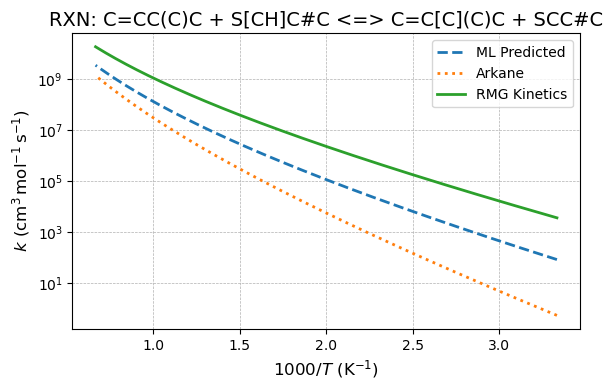

Plotting reaction: CC + [O]O <=> C[CH2] + OO


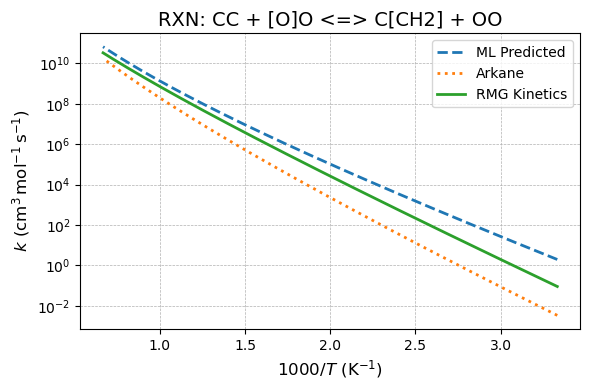

Plotting reaction: CC + [O]O <=> C[CH2] + OO


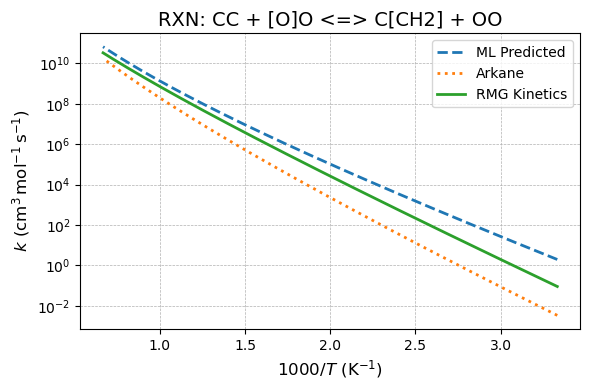

Plotting reaction: CC + [O]O <=> C[CH2] + OO


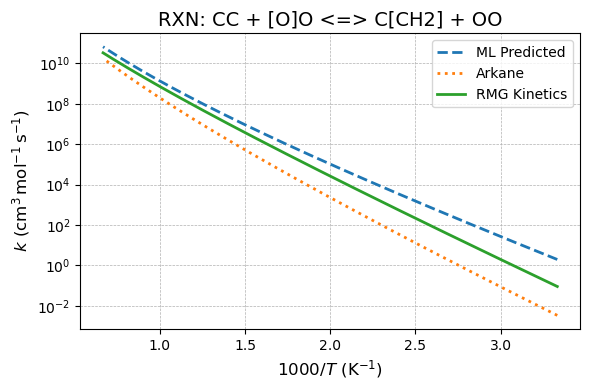

Plotting reaction: CCC1=CC=CC=C1 + C[C](C#C)S <=> CC=C1[CH]C=CC=C1 + CC(C#C)S


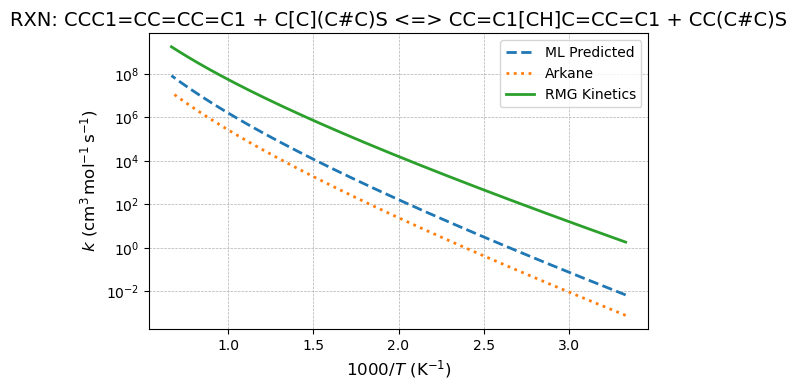

Plotting reaction: CCCOC + [CH2]ON=C <=> CC[CH]OC + CON=C


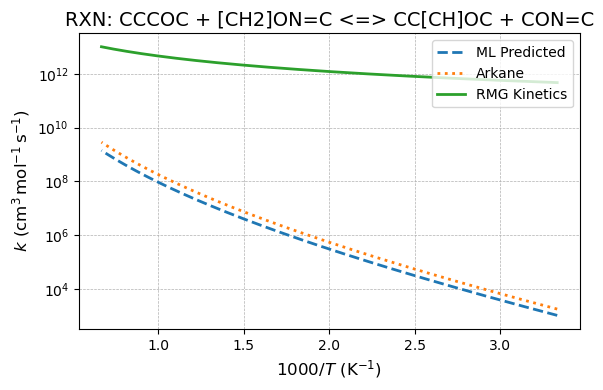

In [76]:
# With the random rows, we now plot the pred_df vs trues_df vs kinetics_rmg_df - they are all connected by rxn_id
smiles = pd.read_csv("/home/calvin/code/chemprop_phd_customised/habnet/data/preprocessing/ordered_reactions_data/ordered_habstraction_smiles.csv")
smiles.drop_duplicates(subset=['rxn'], inplace=True)
import matplotlib.pyplot as plt
# Merge the DataFrames on rxn_id

merged_df = pd.merge(preds_df, trues_df, on='rxn_id', suffixes=('_pred', '_true'))
merged_df = pd.merge(merged_df, kinetics_rmg_df, on='rxn_id', how='left')
# Select the random rows
# If `random_rows` had more than three, pick any three rxn_ids:
# 1) If random_rows had more than three rxn_id’s, sample exactly three:
selected_rxns = random_rows['rxn_id'].sample(4, random_state=0).tolist()

# 2) Build a DataFrame containing just those three:
three_df = merged_df[merged_df['rxn_id'].isin(selected_rxns)].reset_index(drop=True)

# 3) Loop over those three and make one figure per reaction:
for _, row in three_df.iterrows():
    rxn_id = row['rxn_id']
    
    A_pred, n_pred, Ea_pred = row['A_pred'], row['n_pred'], row['Ea_pred']
    A_true, n_true, Ea_true = row['A_true'], row['n_true'], row['Ea_true']
    
    kin_row    = kinetics_rmg_df.loc[kinetics_rmg_df['rxn_id'] == rxn_id].iloc[0]
    A_kin, n_kin, Ea_kin = kin_row['A'], kin_row['n'], kin_row['Ea']
    
    # Compute k(T) on the same T array you already defined
    k_pred = k_arr(A_pred, n_pred, Ea_pred, order=1)
    k_true = k_arr(A_true, n_true, Ea_true, order=1)
    k_kin  = k_arr(A_kin, n_kin, Ea_kin, order=1)
    
    # Prepare the Arrhenius‐style x‐axis: 1000/T
    invT = 1000.0 / T
    
    # Make the title from the smiles datafram via rxn_id and creating a str from the columns r1h + r2 <=> r1 + r2h
    smiles_row = smiles[smiles['rxn'] == rxn_id].iloc[0]
    title_str = f"{smiles_row['r1h']} + {smiles_row['r2']} <=> {smiles_row['r1']} + {smiles_row['r2h']}"
    print(f"Plotting reaction: {title_str}")
    # 4) Make one figure per reaction:
    plt.figure(figsize=(6, 4))
    plt.plot(invT, k_pred, '--', linewidth=2, label='ML Predicted')
    plt.plot(invT, k_true, ':', linewidth=2, label='Arkane')
    plt.plot(invT, k_kin,  '-', linewidth=2, label='RMG Kinetics')
    
    plt.yscale('log')
    plt.xlabel(r'$1000/T\ (\text{K}^{-1})$', fontsize=12)
    plt.ylabel(r'$k\ (\mathrm{cm}^3\,\mathrm{mol}^{-1}\,\mathrm{s}^{-1})$', fontsize=12)
    plt.title(f'RXN: {title_str}', fontsize=14)
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.legend(fontsize=10, loc='upper right')
    plt.tight_layout()
    plt.show()


In [77]:

invT = 1000.0 / T    # shape = (len(T),)

all_k_values = []  # list of 1D numpy arrays

for idx, row in three_df.iterrows():
    # Extract every RMG variant’s Arrhenius parameters:
    A_kin, n_kin, Ea_kin = row['A'], row['n'], row['Ea']
    k_kin = k_arr(A_kin, n_kin, Ea_kin, order=1)
    all_k_values.append(k_kin)

    # Also gather the “Predicted” & “True” curves (they repeat per rxn_id, 
    # but it’s fine to add them once):
    if idx == 0 or three_df.at[idx, 'rxn_id'] != three_df.at[idx - 1, 'rxn_id']:
        # take Pred/True from the first appearance of each rxn_id
        A_pred, n_pred, Ea_pred = row['A_pred'], row['n_pred'], row['Ea_pred']
        k_pred = k_arr(A_pred, n_pred, Ea_pred, order=1)
        all_k_values.append(k_pred)

        A_true, n_true, Ea_true = row['A_true'], row['n_true'], row['Ea_true']
        k_true = k_arr(A_true, n_true, Ea_true, order=1)
        all_k_values.append(k_true)

# Convert list of 1D arrays into a single large array for min/max:
import numpy as np
stacked = np.vstack(all_k_values)  # shape = (N_total_curves, len(T))
y_min = stacked.min()  # smallest k across all curves
y_max = stacked.max()  # largest k across all curves

In [78]:
y_lower = y_min * .5
y_upper = y_max * 1000
x_lower = invT.min() - 0.2  # = 1000 / T.max()
x_upper = invT.max() + 0.2  # = 1000 / T.min()


In [79]:
# pip install rdkit-pypi if you haven't already
from rdkit import Chem

PATTERNS = [
    # (label, SMARTS) – checked in this order
    ("Thiol",      "[SX2H1]"),
    ("Alcohol",    "[OX2H1][CX4]"),
    ("Ether",      "[OX2][CX4]"),
    ("Aldehyde",   "[CX3H1](=O)[#6]"),
    ("Ketone",     "[#6][CX3](=O)[#6]"),
    ("Carboxylic acid", "[CX3](=O)[OX2H1]"),
    ("Amine",      "[NX3;H2,H1]"),
    ("Allylic",    "[CX3H1;$([CX3]=[CX3])]-[CH2]"),
    ("Benzylic",   "[cH]-[CH2]"),
    ("Propargylic","[CX2H1]#[CX]"),
    ("Alkene",     "C=C"),
    ("Alkyne",     "C#C"),
    ("Aromatic",   "a"),
]  # “Alkane” will be the default fall-through

def classify_donor(smiles: str) -> str:
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return "Unparsed"

    for label, patt in PATTERNS:
        if mol.HasSubstructMatch(Chem.MolFromSmarts(patt)):
            return label
    # purely saturated, non-ring → alkane
    if all(atom.GetAtomicNum() == 6 for atom in mol.GetAtoms()):
        return "Alkane"
    return "Other"


Plotting reaction: rmg_rxn_15715


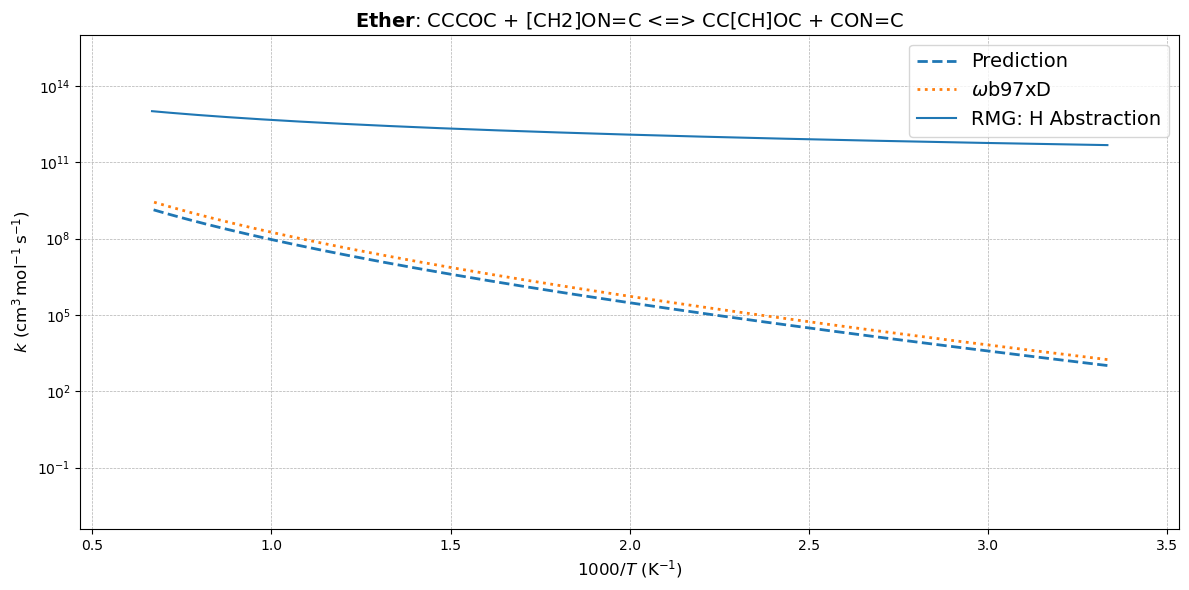

Plotting reaction: rxn_1116


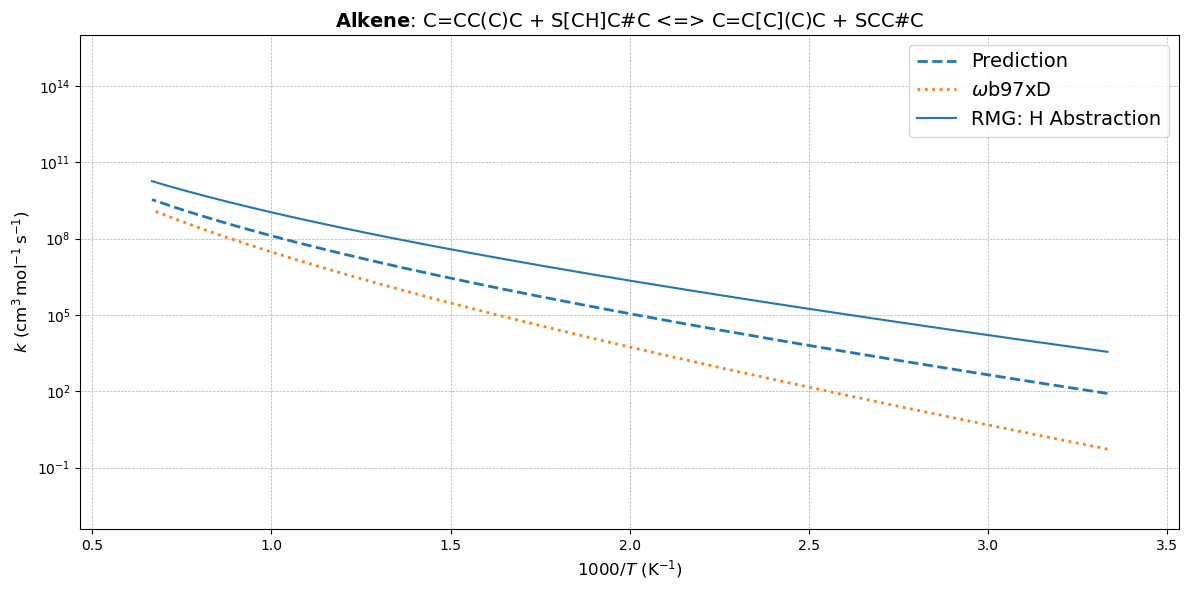

Plotting reaction: rxn_1512


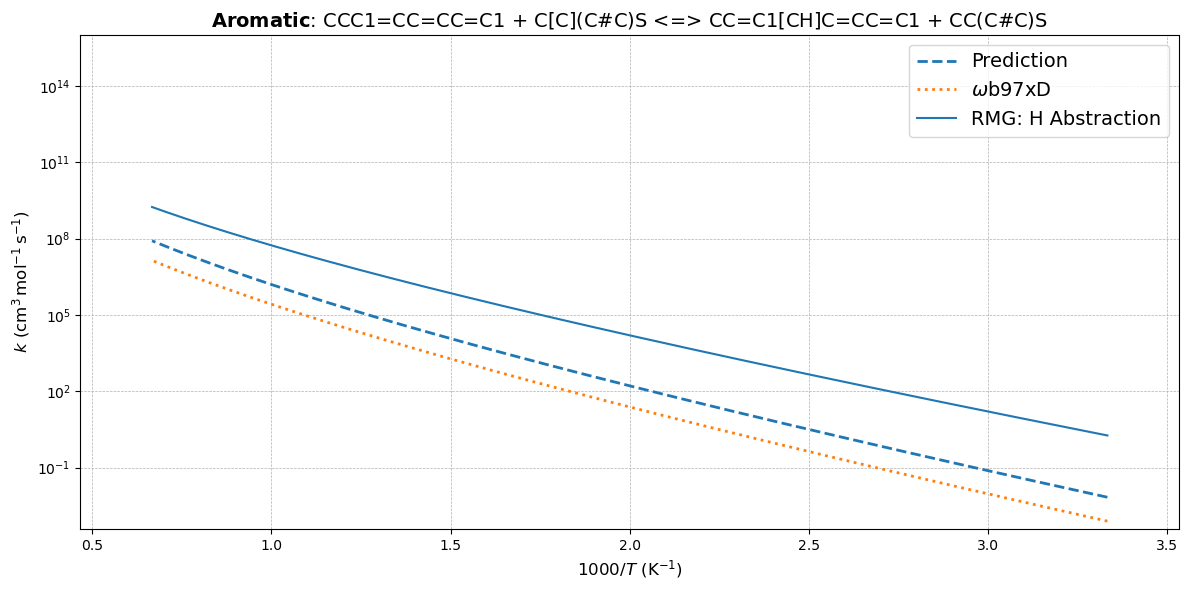

Plotting reaction: rxn_296


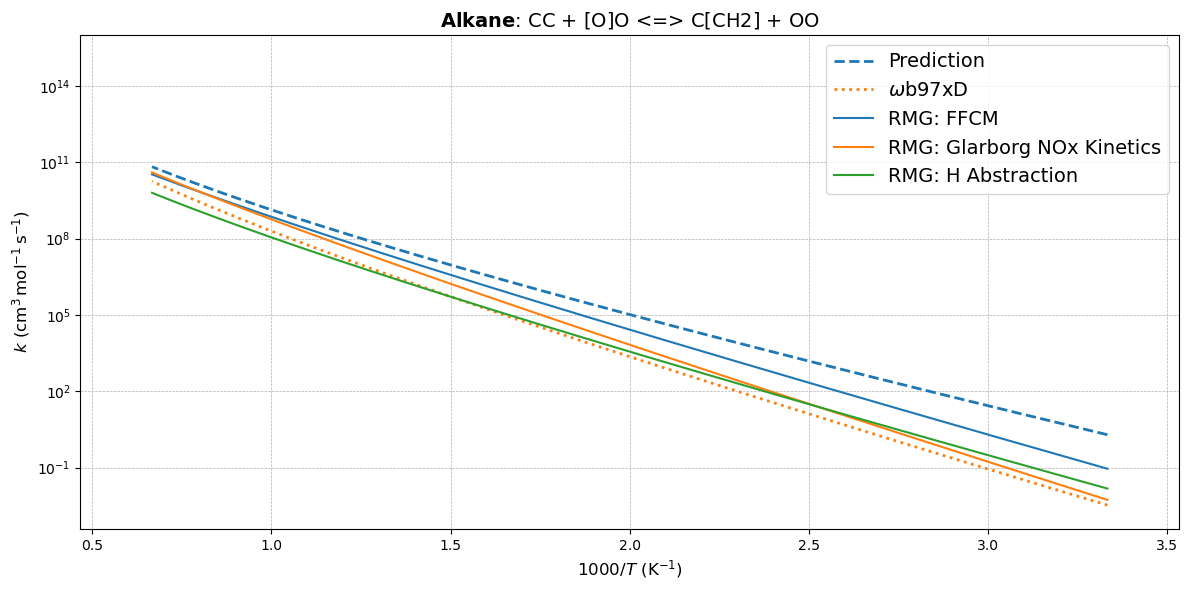

In [80]:
import matplotlib.pyplot as plt

# Group by rxn_id so each reaction’s variants live in the same group
grouped = three_df.groupby('rxn_id')

# Desired figure size (inches). All three will use exactly this:

FIG_W, FIG_H = 12, 6    # inches
DPI = 300              # so final image is 1200×800 p

for rxn_id, group_df in grouped:
    # 1) Pull “Predicted” & “True” from the first row in this group
    first = group_df.iloc[0]
    A_pred, n_pred, Ea_pred = first['A_pred'], first['n_pred'], first['Ea_pred']
    A_true, n_true, Ea_true = first['A_true'], first['n_true'], first['Ea_true']

    # Precompute k_pred, k_true
    k_pred = k_arr(A_pred, n_pred, Ea_pred, order=1)
    k_true = k_arr(A_true, n_true, Ea_true, order=1)

    # 2) Start a new figure (with consistent figsize)
    plt.figure(figsize=(FIG_W, FIG_H))

    # Plot Predicted & True as dashed/dotted lines
    plt.plot(invT, k_pred, linestyle='--', linewidth=2, color='tab:blue', label='Prediction')
    # omega in math form 

    plt.plot(invT, k_true, linestyle=':', linewidth=2, color='tab:orange', label=r'$\omega$b97xD')

    # 3) Loop over every RMG variant in this group
    for idx, row in group_df.iterrows():
        A_kin, n_kin, Ea_kin = row['A'], row['n'], row['Ea']
        
        # Use the 'comment' column to identify which library or source:
        comment = row.get('comment', f'RMG variant {idx}')
        if 'NOx2018' in comment:
            comment = 'Glarborg NOx Kinetics'
        if 'FFCM' in comment:
            comment = 'FFCM'
        if 'H_Abstraction' in comment:
            comment = 'H Abstraction'
        
        k_kin = k_arr(A_kin, n_kin, Ea_kin, order=1)
        plt.plot(invT, k_kin, '-', linewidth=1.5, label=f'RMG: {comment}')

    # 4) Fix the axes limits (same for all figures)
    plt.xlim(x_lower, x_upper)
    plt.ylim(y_lower, y_upper)

    # 5) Label and style
    plt.yscale('log')
    print(f"Plotting reaction: {rxn_id}")
    smiles_row = smiles[smiles['rxn'] == rxn_id].iloc[0]
    title_str = f"{smiles_row['r1h']} + {smiles_row['r2']} <=> {smiles_row['r1']} + {smiles_row['r2h']}"
    
    # Need to get the family of smiles_row['r1h']
    donor_family = classify_donor(smiles_row['r1h'])
    
    plt.xlabel(r'$1000/T\ (\mathrm{K}^{-1})$', fontsize=12)
    plt.ylabel(r'$k\ (\mathrm{cm}^{3}\,\mathrm{mol}^{-1}\,\mathrm{s}^{-1})$', fontsize=12)
    plt.title(r"$\bf{" +  str(donor_family) +r"}$: " + f"{title_str}", fontsize=14)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.legend(fontsize=14, loc='upper right')
    plt.tight_layout()

    # 6) Show (or save) the figure
    plt.show()
    # If you prefer saving each as a png for uniform dimensions & DPI:
    # plt.savefig(f"{rxn_id}_arrhenius.png", dpi=300)
    # plt.close()


In [81]:
trues_df[trues_df['rxn_id'] == 'rxn_296']

,A,n,Ea,rxn_id
56,0.333955,4.15256,70.535995,rxn_296
